In [1]:
from Functions_base import ic_twofield, omega_base, theta_base, delta_base, Temerge
from Functions_analysis import Y
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from Functions_IPM import run_year_mix2, eps, biocontrol
import matplotlib as mpl

# Import ascospore data
growth_delay = np.load("dd_delay.npy")
prop_asc = np.load("prop_asc.npy")

# Functions for plotting aesthetics
from Functions_plotting import c1,c2,c3,c4,c5
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
this_c = [c2,c3,c4,c5]

In [2]:
# IPM parameters, one for the "default" scenario, and an array for the low-medium-high scenarios
r_beta = 0.976
r_beta_range = [0.997,0.976,0.958]

sow_delay = 30
sow_delay_range = [15,30,38]

prop_debris = 0.1
prop_debris_range=[0,0.1,0.899]

debris_removal = 0.154
debris_removal_range = [0.154,0.154,0]

biocontrol_dates = [31,39]
biocontrol_dates_range = [[],[31],[31,39]]

# Default scenario

[[0.02       0.97923246 0.97825192]
 [0.04       0.97941775 0.97845513]
 [0.06       0.97960217 0.97865702]
 [0.08       0.97978447 0.97885741]
 [0.1        0.97996583 0.97905655]
 [0.12       0.98014551 0.97925408]
 [0.14       0.98032342 0.97945005]
 [0.16       0.98049948 0.9796443 ]
 [0.18       0.98067381 0.97983687]
 [0.2        0.98084625 0.98002767]
 [0.22       0.98101675 0.9802166 ]
 [0.24       0.98118545 0.98040383]
 [0.26       0.98135177 0.98058883]
 [0.28       0.98151601 0.98077185]
 [0.3        0.98167792 0.98095266]
 [0.32       0.98183752 0.98113133]
 [0.34       0.98199451 0.98130745]
 [0.36       0.98214906 0.98148134]
 [0.38       0.98230085 0.98165256]
 [0.4        0.98244976 0.98182103]
 [0.42       0.98259574 0.98198679]
 [0.44       0.98273838 0.98214931]
 [0.46       0.98287803 0.98230907]
 [0.48       0.98301423 0.98246548]
 [0.5        0.98314665 0.9826183 ]
 [0.52       0.98327546 0.98276782]
 [0.54       0.98339999 0.98291311]
 [0.56       0.98352036 0.98

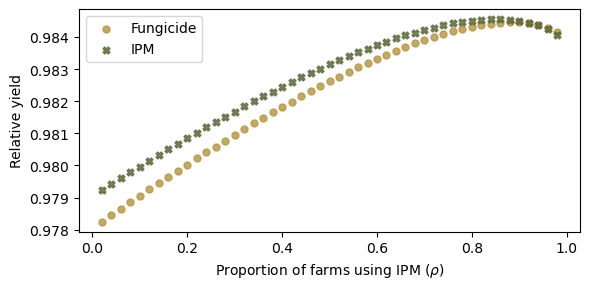

In [3]:
# Run simulation for each proportion
it = 0.02
prop = np.arange(it,1.0,0.02)
all_YI = np.zeros(len(prop))
all_YF = np.zeros(len(prop))
Nprop = len(prop)

for i in range(len(prop)):
    p = prop[i]
    ic = 1*ic_twofield
    t,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega_base,theta_base,delta_base)
    
    # Compute yields
    all_YI[i] = Y(pop[:,:6]/p)
    all_YF[i] = Y(pop[:,6:]/(1-p))

# Plot figure
fig,ax = plt.subplots(1,figsize = (6,3))
ax.scatter(prop,all_YF,label="Fungicide",c=c2,alpha=0.8,s=25)
ax.scatter(prop,all_YI,label="IPM",c=c4,marker='X',alpha=0.8,s=25)
ax.set_xlabel(r"Proportion of farms using IPM ($\rho$)")
ax.set_ylabel("Relative yield")
ax.legend(loc = "upper left")
plt.tight_layout()

# Save figure
fig.savefig('Figures/Manuscript_final/fig_defaultresult.pdf', dpi=400,bbox_inches='tight')

print(np.array([prop,all_YI,all_YF]).T)

In [4]:
# Run simulations across all proportions, get yield and FOI over time
def get_Y_FOI(r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega,theta,delta,per_capita):
    
    # Set up storage vectors
    all_YI = np.zeros(Nprop)
    all_YF = np.zeros(Nprop)
    FOI_plain = np.zeros((Nprop,4,Ntime)) # Order: I_I, P_I, I_F, P_F
    FOI_b = np.zeros((Nprop,4,Ntime))
    FOI_f = np.zeros((Nprop,4,Ntime))
    
    # Run across all proportions
    for k in range(Nprop):
        p = prop[k]
        all_YI[k], all_YF[k], FOI_plain[k], FOI_b[k], FOI_f[k] = get_Y_FOI_p(p,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega,theta,delta,per_capita)
    
    return all_YI, all_YF, FOI_plain, FOI_b, FOI_f

# Compute yield and FOI for a given proportion
def get_Y_FOI_p(p,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega,theta,delta,per_capita):
        
    # Run simulation
    ic = 1*ic_twofield
    _,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega,theta,delta)

    # Compute yields
    all_YI = Y(pop[:,:6]/p)
    all_YF = Y(pop[:,6:]/(1-p))

    # Compute fungicide and biocontrols
    fungicide = np.zeros(len(t_growing))
    for i in range(len(fungicide)):
        fungicide[i] = 1-eps(t_growing[i],omega,theta,delta)

    b = np.zeros(len(t_growing))
    for i in range(len(b)):
        b[i] = 1-biocontrol(biocontrol_dates)(t_growing[i],growth_delay[sow_delay])

    # Compute FOIs
    A = 1*np.sum(pop[:,:6],axis=1) + 1*np.sum(pop[:,6:-1],axis=1)
    these_pop = 1*pop[:,[2,5,8,11]].T
    these_pop[0] *= r_beta
    these_pop[1] *= r_beta

    FOI_out = these_pop
    FOI_b = FOI_out*b*r_beta
    FOI_f = FOI_out*fungicide
        
    return all_YI, all_YF, FOI_out, FOI_b, FOI_f

# Get time vector
t_growing,_ = run_year_mix2(ic_twofield,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,0.5,omega_base,theta_base,delta_base)
Ntime = len(t_growing)

# Varied regime intensities
Plots one 3x3 figure for yields, and one 3x3 figure for FOI contributions from each compartment.

In [5]:
# Checking that the edge cases line up with the single-field yields
p = 0.00001
ic = 1*ic_twofield
t,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega_base,theta_base,delta_base)
print(Y(pop[:,6:]/(1-p)))

p = 1 - p
ic = 1*ic_twofield
t,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega_base,theta_base,delta_base)
print(Y(pop[:,:6]/p))

0.978047470046913
0.9837641162117106


In [6]:
# Plot details
Nipm = 3
Nf = 3
per_capita = True

In [7]:
# Plot yields
def plot_y(ax, all_YI, all_YF,inset = False):
    ax.scatter(prop[::2],all_YF[::2],label = "Fungicide \nregime",c=c2,alpha=0.8)
    ax.scatter(prop[::2],all_YI[::2],label = "IPM \nregime",edgecolors=c4,marker='X',alpha=0.8,facecolors=c4)
    ax.set_xlim([0,1])
    ax.set_ylim([0.85,1])
    
    if inset == True:
        # Plot inset
        inset_ax = inset_axes(ax,width='70%',height=1, loc="center right",borderpad=1.1)
        inset_ax.scatter(prop[::2],all_YF[::2],c=c2,alpha=0.8,s=11)
        inset_ax.scatter(prop[::2],all_YI[::2],edgecolors=c4,marker='X',alpha=0.8,facecolors=c4,s=11)
        inset_ax.set_xlim([0,1])       
        
    return ax

# Plot FOI on a [type] of farm
def plot_FOI(ax,FOI):
    labels = ["I_I","P_I","I_F","P_F"]
    for k in range(4):
        ax.fill_between(prop,np.sum(FOI[:,:k],axis=1),np.sum(FOI[:,:k+1],axis=1),label = labels[k],color=this_c[k])
    ax.set_xlim([0,1])
    return ax

i = 0omega = 0.5
[[0.02       0.90514306 0.90862301]
 [0.04       0.90487984 0.90834331]
 [0.06       0.90462101 0.90806725]
 [0.08       0.90436689 0.90779515]
 [0.1        0.90411646 0.90752599]
 [0.12       0.90387087 0.90726087]
 [0.14       0.90362932 0.90699903]
 [0.16       0.90339227 0.9067409 ]
 [0.18       0.90315911 0.90648586]
 [0.2        0.90293027 0.90623433]
 [0.22       0.90270509 0.90598566]
 [0.24       0.9024841  0.90574033]
 [0.26       0.90226667 0.90549774]
 [0.28       0.90205199 0.90525707]
 [0.3        0.90184222 0.90502042]
 [0.32       0.90163413 0.90478462]
 [0.34       0.9014288  0.9045507 ]
 [0.36       0.90122609 0.90431853]
 [0.38       0.90102559 0.90408767]
 [0.4        0.90082617 0.90385701]
 [0.42       0.90062773 0.90362641]
 [0.44       0.90043003 0.90339564]
 [0.46       0.90023128 0.9031629 ]
 [0.48       0.90003249 0.90292919]
 [0.5        0.89983087 0.90269168]
 [0.52       0.89962584 0.90244979]
 [0.54       0.89941752 0.90220362]
 [0.56     

i = 1omega = 1.0
[[0.02       0.97719693 0.97817519]
 [0.04       0.97732634 0.97830292]
 [0.06       0.97745539 0.9784305 ]
 [0.08       0.97758407 0.97855787]
 [0.1        0.97771241 0.97868509]
 [0.12       0.97784018 0.97881194]
 [0.14       0.97796741 0.97893843]
 [0.16       0.97809388 0.97906439]
 [0.18       0.97821961 0.97918984]
 [0.2        0.97834447 0.97931466]
 [0.22       0.97846831 0.97943872]
 [0.24       0.97859131 0.97956221]
 [0.26       0.97871297 0.97968461]
 [0.28       0.97883337 0.97980606]
 [0.3        0.97895238 0.97992641]
 [0.32       0.97906989 0.9800456 ]
 [0.34       0.97918558 0.98016329]
 [0.36       0.9792996  0.9802797 ]
 [0.38       0.97941158 0.98039444]
 [0.4        0.97952126 0.98050725]
 [0.42       0.97962869 0.98061827]
 [0.44       0.97973328 0.98072686]
 [0.46       0.97983541 0.98083351]
 [0.48       0.97993435 0.98093744]
 [0.5        0.98002992 0.98103853]
 [0.52       0.98012216 0.98113693]
 [0.54       0.98021009 0.98123154]
 [0.56     

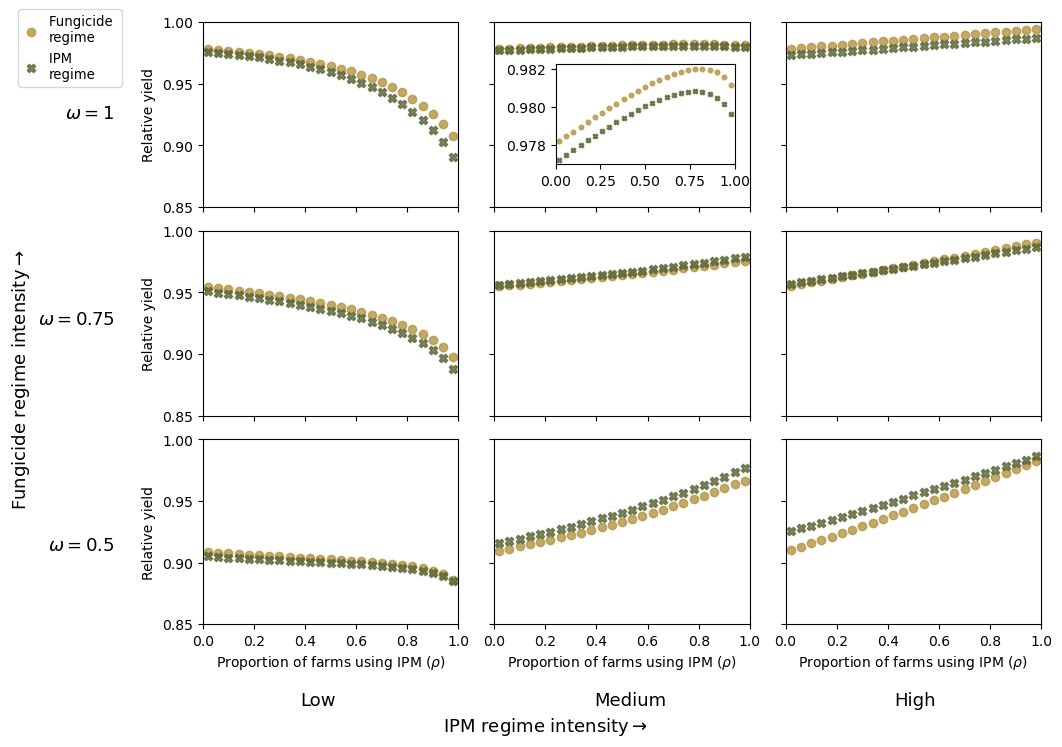

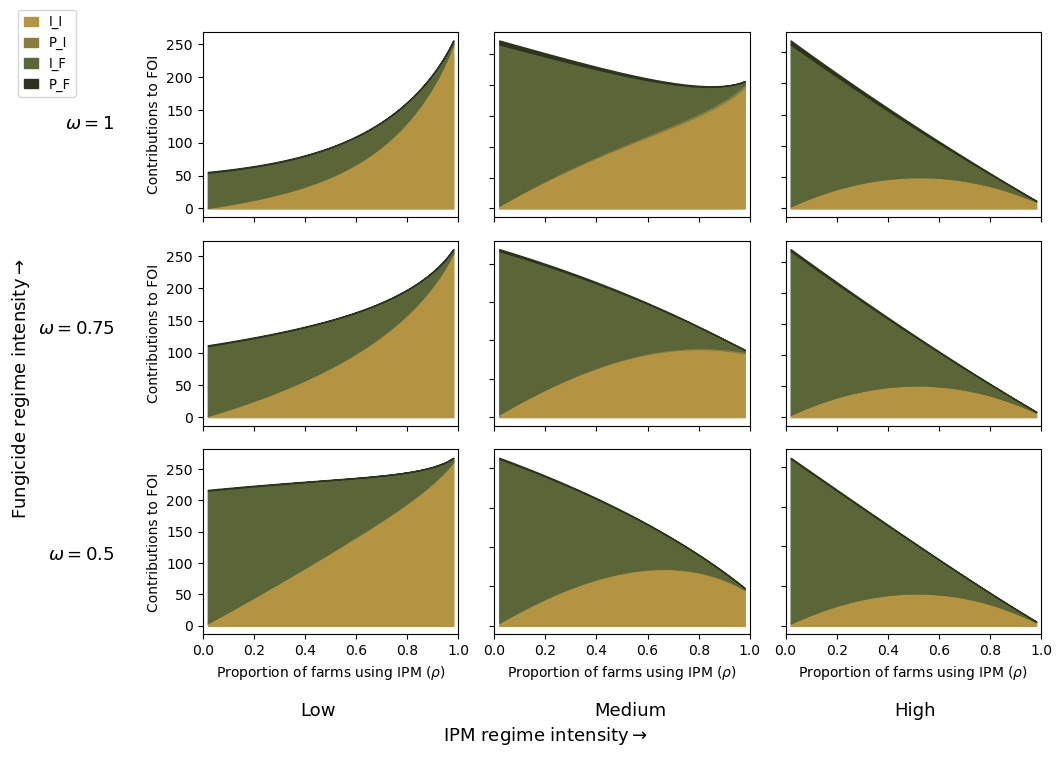

In [8]:
# Set up figures
figY,axesY = plt.subplots(1,figsize = (11,8))
figFOIp,axesFOIp = plt.subplots(1,figsize = (11,8))
locs = [["upper left", "upper center", "upper right"],["center left", "center", "center right"],["lower left", "lower center", "lower right"]]

for i in range(Nipm):
    for j in range(Nf):        
        YI, YF, FOI_plain, FOI_b, FOI_f = get_Y_FOI(r_beta_range[i],sow_delay_range[i],prop_debris_range[i],debris_removal_range[i],biocontrol_dates_range[i], omega_base*(j+2)/4, theta_base, delta_base,per_capita)
        
        print("i = " + str(i) + "omega = " + str(omega_base*(j+2)/4))
        toprint = np.stack((prop,YI,YF))
        print(toprint.T)
        
        # Yield plots - with and without insets, done manually
        if (i == 1 and j == 2):
            inset_axY = inset_axes(axesY,width='30%',height='30%',loc=locs[Nf-1-j][i],borderpad=0.5,bbox_to_anchor=(0.09, 0.09, 1, 1), bbox_transform=axesY.transAxes)
            inset_axY = plot_y(inset_axY,YI, YF,True)
        else:
            inset_axY = inset_axes(axesY,width='30%',height='30%',loc=locs[Nf-1-j][i],borderpad=0.5,bbox_to_anchor=(0.09, 0.09, 1, 1), bbox_transform=axesY.transAxes)
            inset_axY = plot_y(inset_axY,YI, YF)
        
        # FOI plots
        inset_axFOIp = inset_axes(axesFOIp,width='30%',height='30%',loc=locs[Nf-1-j][i],borderpad=0.5,bbox_to_anchor=(0.09, 0.09, 1, 1), bbox_transform=axesY.transAxes)
        inset_axFOIp = plot_FOI(inset_axFOIp,np.trapz(FOI_plain))
        
        # Show y axis labels where relevant
        if i != 0:
            inset_axY.tick_params(labelleft=False)
            inset_axFOIp.tick_params(labelleft=False)
        else:
            inset_axY.set_ylabel("Relative yield")
            inset_axFOIp.set_ylabel("Contributions to FOI")
            
        # Show x axis labels where relevant
        if j != 0:
            inset_axY.tick_params(labelbottom=False)
            inset_axFOIp.tick_params(labelbottom=False)
        else:
            inset_axY.set_xlabel(r"Proportion of farms using IPM ($\rho$)")
            inset_axFOIp.set_xlabel(r"Proportion of farms using IPM ($\rho$)")
        
# Yield figure details
axesY.set_xlabel("IPM regime intensity"+ r"$\rightarrow$" ,fontsize=13)
axesY.set_ylabel("Fungicide regime intensity" + r"$\rightarrow$",fontsize=13)
axesY.set_xticks([0.7,1.8,2.8,3],labels=["Low","Medium","High",""],fontsize=13)
axesY.set_yticks([0.7,1.8,2.8,3],labels=["$\omega = 0.5$","$\omega = 0.75$","$\omega = 1$",""],fontsize=13)
axesY.tick_params(axis=u'both', which=u'both',length=0)

axesY.spines["top"].set_visible(False)
axesY.spines["right"].set_visible(False)
axesY.spines["bottom"].set_visible(False)
axesY.spines["left"].set_visible(False)

inset_axY.legend(loc = [-3,0.65],fontsize=9.5,handlelength=1.1)

# Save figure
figY.savefig('Figures/Manuscript_final/fig_3x3.pdf', dpi=400)

# FOI figure details
axesFOIp.set_xlabel("IPM regime intensity"+ r"$\rightarrow$" ,fontsize=13)
axesFOIp.set_ylabel("Fungicide regime intensity" + r"$\rightarrow$",fontsize=13)
axesFOIp.set_xticks([0.7,1.8,2.8,3],labels=["Low","Medium","High",""],fontsize=13)
axesFOIp.set_yticks([0.7,1.8,2.8,3],labels=["$\omega = 0.5$","$\omega = 0.75$","$\omega = 1$",""],fontsize=13)
axesFOIp.tick_params(axis=u'both', which=u'both',length=0)

axesFOIp.spines["top"].set_visible(False)
axesFOIp.spines["right"].set_visible(False)
axesFOIp.spines["bottom"].set_visible(False)
axesFOIp.spines["left"].set_visible(False)

inset_axFOIp.legend(loc = [-3,0.65],fontsize=9.5,handlelength=1.1)

# if per_capita == True:
#     axesFOIp.set_title("Contributions (per capita) to FOI on unit farm",fontsize=14)
# else:
#     axesFOIp.set_title("Contributions to FOI on unit farm",fontsize=14)